<a href="https://colab.research.google.com/github/Abhi310/Air_Quality_analysis_and_prediction/blob/master/Air_quality_linear_randforest_svm_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS AND FUNCTIONS

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [0]:
#Constants to classify the resluts of prediction in diferent group.
DIFF_FOR_PERFECT = 0.1
DIFF_FOR_EXCELLENT = 0.2
DIFF_FOR_GOOD =  0.4
DIFF_FOR_OK = 0.6


In [0]:
#Preinting the classified results.
def print_results(test_data,pred_data):
    perfect, excellent, good, ok, bad=0, 0, 0, 0, 0
    for i in range(test_data.size):
        if pred_data[i]>(test_data[i]-DIFF_FOR_PERFECT) and pred_data[i]<(test_data[i]+DIFF_FOR_PERFECT):
            perfect += 1
            continue
        
        if pred_data[i]>(test_data[i]-DIFF_FOR_EXCELLENT) and pred_data[i]<(test_data[i]+DIFF_FOR_EXCELLENT):
            excellent += 1
            continue
        
        if pred_data[i]>(test_data[i]-DIFF_FOR_GOOD) and pred_data[i]<(test_data[i]+DIFF_FOR_GOOD):
            good += 1
            continue
        
        if pred_data[i]>(test_data[i]-DIFF_FOR_OK) and pred_data[i]<(test_data[i]+DIFF_FOR_OK):
            ok += 1
            continue
        
        if pred_data[i]>(test_data[i]-0.01) and pred_data[i]<(test_data[i]+0.01):
            perfect += 1
            continue
        else:
            bad+=1
    
    print("Perfect Predictions:   " + str(perfect)+ "\nExcellent Predictions: " + str(excellent) + "\nGood Predictions:      " + str(good) + "\nQuite OK Predictions:  " + str(ok) + "\nBad Predictions:       " + str(bad))
    per = (perfect+excellent+good+ok)*100/test_data.size
    print('\nPercent of Considerable Predictions: ' + str(round(per,2)) + '%')


In [0]:
def line_graph(y_test, y_pred, xdim_len=100):
    plt.figure(figsize=(15,6))
    plt.plot(y_test[0:xdim_len], label='Test Label')
    plt.plot(y_pred[0:xdim_len], label='Predictions')
    plt.legend()
    
def plot_error(y_test, y_pred):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title('Distribution of error')
    sns.distplot(y_test-y_pred)
    
    plt.subplot(1,2,2)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.ylabel('Predictions')
    plt.xlabel('Test Label')
    
    
def print_error(model_name, y_test, y_pred):
    error = y_test - y_pred
    error_ab = y_test - y_pred
    for i  in range(len(error)):
        if error[i]<0: error_ab[i]=error_ab[i]*(-1)
        error_sq = error**2
    print(model_name + ' MODEL:')
    print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab.mean()))
    print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq.mean()))
    

# DATA MANIPULATION

The Dataset is taken from UCI website. the link to dataset is: http://archive.ics.uci.edu/ml/datasets/air+quality

In [0]:
from google.colab import files
uploaded = files.upload()

Saving AirQualityUCI.xlsx to AirQualityUCI (2).xlsx


In [0]:
df = pd.read_excel('AirQualityUCI.xlsx')
print('Shape of Data Frame: ',df.shape)
df.head(3)

Shape of Data Frame:  (9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.9,53.975000,0.750239


It is mentioned, the value of -200 means the value is missing.

In [0]:
for col in df.columns:
    print('Missing values in ' + col + ':\t' + str(len(df[df[col]==-200])))

Missing values in Date:	0
Missing values in Time:	0
Missing values in CO(GT):	1683
Missing values in PT08.S1(CO):	366
Missing values in NMHC(GT):	8443
Missing values in C6H6(GT):	366
Missing values in PT08.S2(NMHC):	366
Missing values in NOx(GT):	1639
Missing values in PT08.S3(NOx):	366
Missing values in NO2(GT):	1642
Missing values in PT08.S4(NO2):	366
Missing values in PT08.S5(O3):	366
Missing values in T:	366
Missing values in RH:	366
Missing values in AH:	366


Column NMHC(GT) has 8443 missing values out of 9357, so we will drop this column.
Column CO(GT), NOx(GT) and  NO2(GT) has 1683 values out of 9357 values are missing. 

In [0]:
df=df[(df['PT08.S2(NMHC)']!=-200)&(df['NOx(GT)']!=-200)&(df['CO(GT)']!=-200)]
df=df.drop(columns={'NMHC(GT)'})

In [0]:
df = df.replace(-200.00,np.NaN)

df = df.fillna(df.mean())

for col in df.columns:
    print('Missing values in ' + col + ':\t' + str(len(df[df[col]==-200])))

Missing values in Date:	0
Missing values in Time:	0
Missing values in CO(GT):	0
Missing values in PT08.S1(CO):	0
Missing values in C6H6(GT):	0
Missing values in PT08.S2(NMHC):	0
Missing values in NOx(GT):	0
Missing values in PT08.S3(NOx):	0
Missing values in NO2(GT):	0
Missing values in PT08.S4(NO2):	0
Missing values in PT08.S5(O3):	0
Missing values in T:	0
Missing values in RH:	0
Missing values in AH:	0


Now we have no more missing values.

In [0]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000
mean,2.182488,1119.772813,10.555515,958.477151,250.609965,816.731651,113.858608,1452.659922,1057.632200,17.758092,48.873123,0.985678
std,1.440863,218.697536,7.463805,264.010540,208.571553,251.853737,47.454450,353.283017,406.418998,8.846898,17.433063,0.401046
min,0.100000,647.250000,0.181525,390.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.100000,956.625000,4.927071,759.750000,103.000000,642.250000,79.000000,1206.875000,759.500000,11.200000,35.318750,0.694156
50%,1.900000,1084.750000,8.791441,931.125000,186.000000,785.375000,110.000000,1457.625000,1006.250000,16.850000,49.175000,0.954064
75%,2.900000,1253.812500,14.579057,1135.250000,334.375000,946.500000,142.000000,1683.062500,1322.000000,23.725000,62.224999,1.251619
max,11.900000,2039.750000,63.741476,2214.000000,1479.000000,2682.750000,332.600000,2775.000000,2522.750000,44.600000,88.725000,2.180639


In [0]:
p = []
for i in df['PT08.S1(CO)']:
    p.append(i/650)

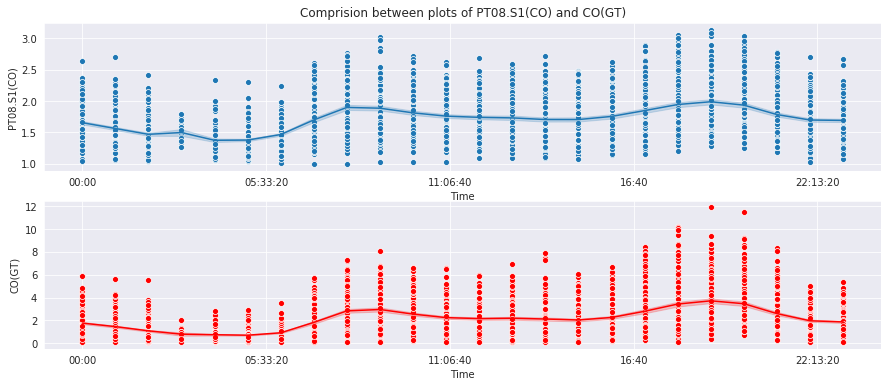

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
plt.title('Comprision between plots of PT08.S1(CO) and CO(GT)')
sns.scatterplot(y=p, x=df['Time'])
sns.lineplot(y=p, x=df['Time'])
plt.ylabel('PT08.S1(CO)')

plt.subplot(2,1,2)
sns.scatterplot(y=df['CO(GT)'], x=df['Time'], color='red')
sns.lineplot(y=df['CO(GT)'], x=df['Time'], color='red');


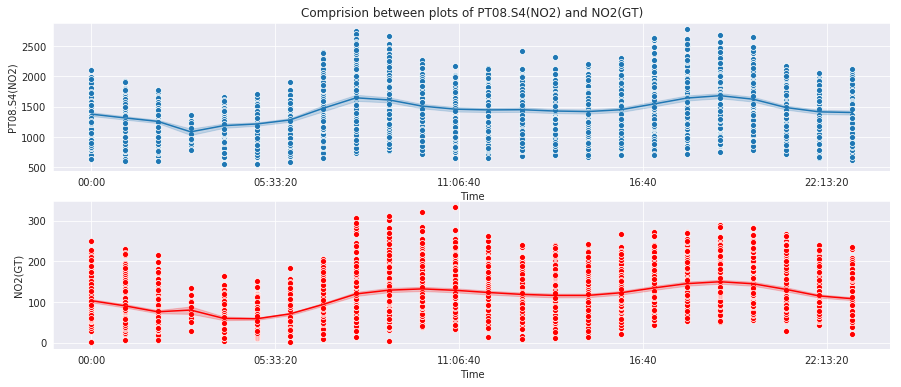

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.title('Comprision between plots of PT08.S4(NO2) and NO2(GT)')
sns.scatterplot(y=df['PT08.S4(NO2)'], x=df['Time'])
sns.lineplot(y=df['PT08.S4(NO2)'], x=df['Time'])

plt.subplot(2,1,2)
sns.scatterplot(y=df['NO2(GT)'], x=df['Time'], color='red')
sns.lineplot(y=df['NO2(GT)'], x=df['Time'], color='red');

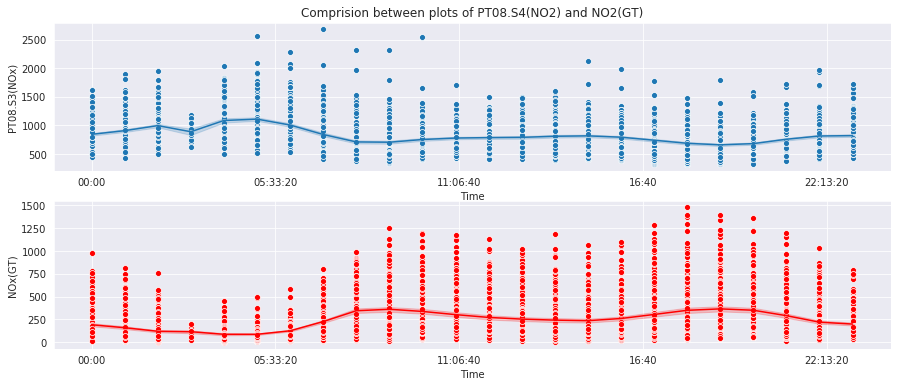

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.title('Comprision between plots of PT08.S4(NO2) and NO2(GT)')
sns.scatterplot(y=df['PT08.S3(NOx)'], x=df['Time'])
sns.lineplot(y=df['PT08.S3(NOx)'], x=df['Time'])

plt.subplot(2,1,2)
sns.scatterplot(y=df['NOx(GT)'], x=df['Time'], color='red')
sns.lineplot(y=df['NOx(GT)'], x=df['Time'], color='red');

In [0]:
import datetime
#df[df['Time']==datetime.time(4, 0)]

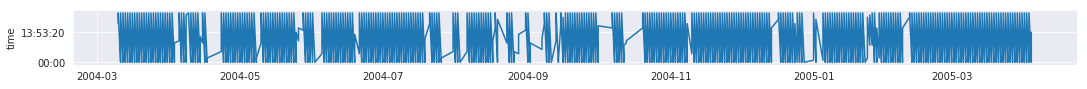

In [0]:
plt.figure(figsize=(18,1))
plt.plot(df['Date'],df['Time']);

The data is not uniform there are many missing days or series of missing days in the data

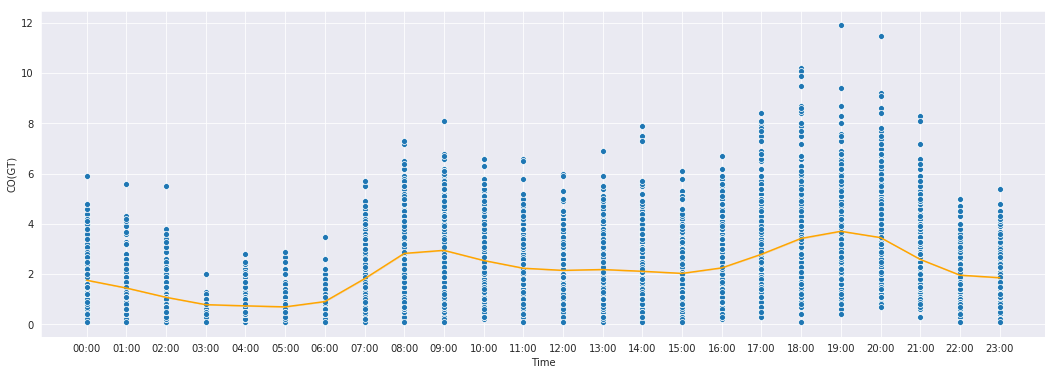

In [0]:
#df[df['CO(GT)']>7]
time=[]
for i in range(24):
    hr = str(i) + ':00'
    time.append(hr)
    
plt.figure(figsize=(18,6))
sns.scatterplot(df['Time'], df['CO(GT)'])
sns.lineplot(df['Time'], df['CO(GT)'], ci=0, color='orange')
plt.xticks(time);

We can clearly see the amount of CO in air is at most during 18:00 to 20:00 and least around 03:00 to 6:00.

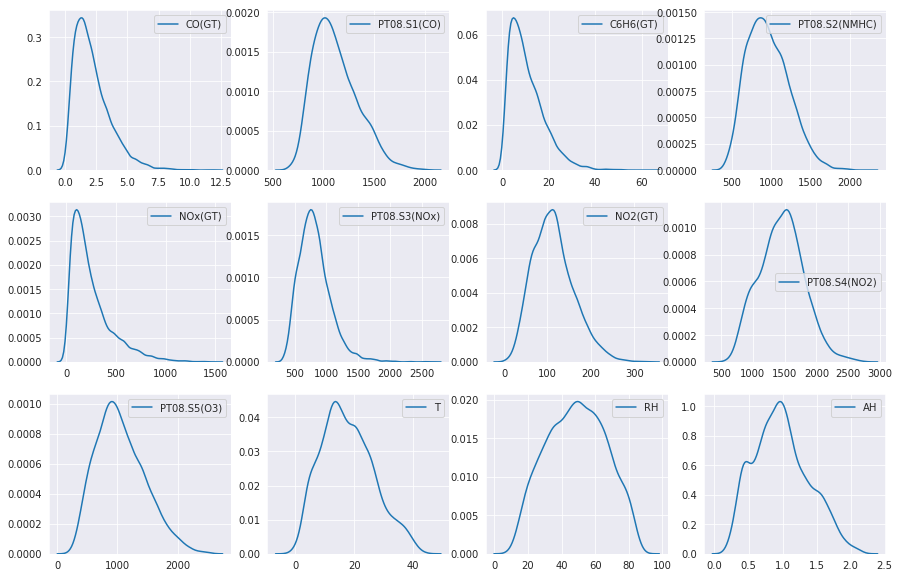

In [0]:
plt.figure(figsize=(15,10))
i=1
column_list = df.columns.values[2:]
for col in column_list:
    plt.subplot(3,4,i)
    sns.kdeplot(df[col])
    i+=1;


In [0]:
df = df.drop(columns={'PT08.S1(CO)','PT08.S4(NO2)','Date','Time'})

In [0]:
train_dataset = df.sample(frac=0.9,random_state=0)
test_dataset = df.drop(train_dataset.index)
#print('Traindata shape: ' + str(train_dataset.shape))
#print('Testdata shape: ' +  str(test_dataset.shape))

train_stats = train_dataset.describe()
train_stats.pop("CO(GT)")
train_stats = train_stats.transpose()
train_stats

y_train = train_dataset.pop('CO(GT)')
y_test = test_dataset.pop('CO(GT)')

X_train = np.asarray(train_dataset)
X_test = np.asarray(test_dataset)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
norm_X_train = np.asarray(norm(train_dataset))
norm_X_test = np.asarray(norm(test_dataset))



In [0]:
print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

print('norm X train size: ', norm_X_train.shape)
print('norm X test size: ', norm_X_test.shape)

X train size:  (6250, 9)
y train size:  (6250,)
X test size:  (694, 9)
y test size:  (694,)
norm X train size:  (6250, 9)
norm X test size:  (694, 9)


# LINEAR REGRESSION

In [0]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train);


In [0]:
y_pred_linear = regressor.intercept_ + X_test.dot(regressor.coef_)


In [0]:
print_results(y_test,y_pred_linear)

Perfect Predictions:   191
Excellent Predictions: 153
Good Predictions:      219
Quite OK Predictions:  57
Bad Predictions:       74

Percent of Considerable Predictions: 89.34%


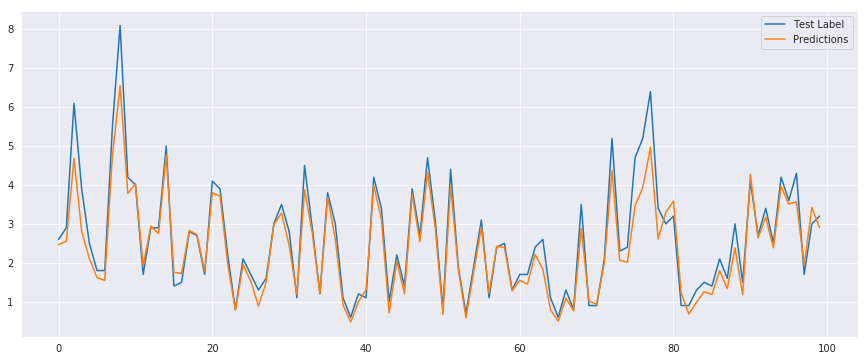

In [0]:
line_graph(y_test, y_pred_linear);

In [0]:
print_error('Linear', y_test, y_pred_linear)

Linear MODEL:
	Mean Absolute Error on Test Set: 0.29
	Mean Square Error on Test Set: 0.20


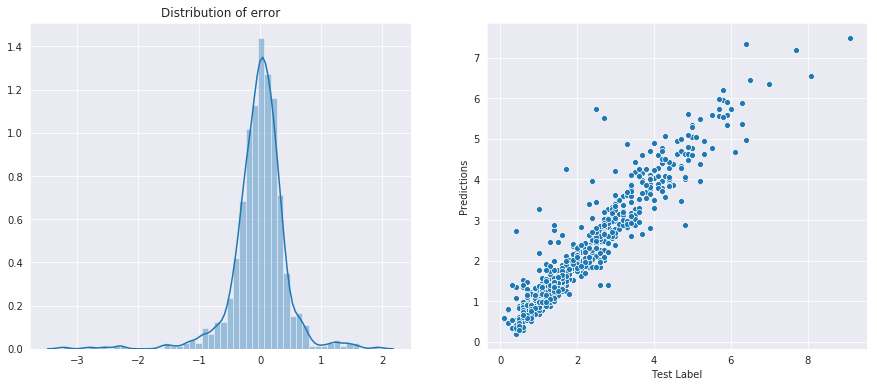

In [0]:
plot_error(y_test,y_pred_linear)



---



---



# RANDOM FOREST

In [0]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200,random_state=0)
model.fit(norm_X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
y_pred_randforest = model.predict(norm_X_test)

In [0]:
print_results(y_test,y_pred_randforest)

Perfect Predictions:   249
Excellent Predictions: 162
Good Predictions:      169
Quite OK Predictions:  50
Bad Predictions:       64

Percent of Considerable Predictions: 90.78%


In [0]:
print_error('Random Forest', y_test, y_pred_randforest)

Random Forest MODEL:
	Mean Absolute Error on Test Set: 0.25
	Mean Square Error on Test Set: 0.18


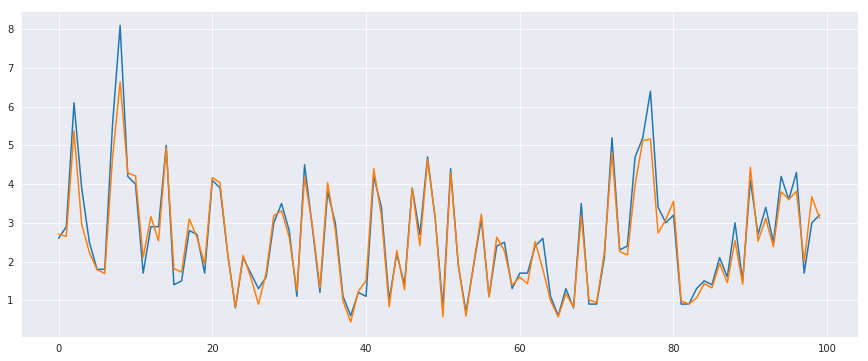

In [0]:
line_graph(y_test, y_pred_randforest)

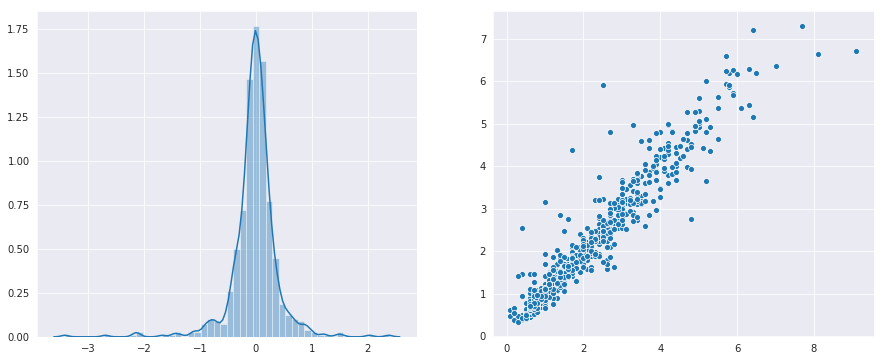

In [0]:
plot_error(y_test, y_pred_randforest)

# SUPPORT VECTOR MACHINE

In [0]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#norm_X_train = scaler.fit_transform(X_train)
#norm_X_test = scaler.fit_transform(X_test)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


model = SVR(kernel='rbf', gamma='scale')
model.fit(norm_X_train, y_train)

y_pred_svm = model.predict(norm_X_test);

In [0]:
print_results(y_test, y_pred_svm)

Perfect Predictions:   250
Excellent Predictions: 171
Good Predictions:      162
Quite OK Predictions:  53
Bad Predictions:       58

Percent of Considerable Predictions: 91.64%


In [0]:
print_error('SVM', y_test, y_pred_svm)

SVM MODEL:
	Mean Absolute Error on Test Set: 0.24
	Mean Square Error on Test Set: 0.16


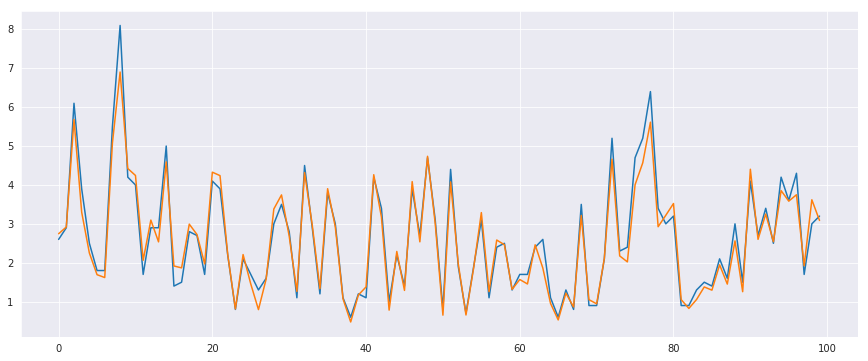

In [0]:
line_graph(y_test, y_pred_svm)

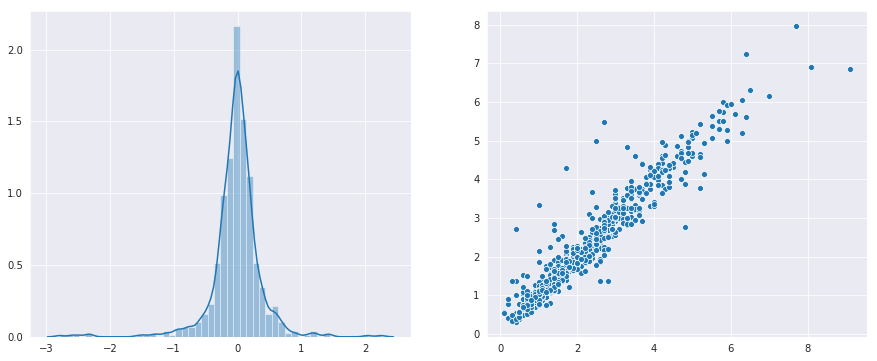

In [0]:
plot_error(y_test, y_pred_svm)



---



# NEURAL NETWORK

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu, input_shape=[norm_X_train.shape[1]]),
        keras.layers.Dropout(0.2),
        #keras.layers.BatchNormalization(),
        #keras.layers.Dense(128, activation=tf.nn.relu),
        #keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(16, activation=tf.nn.relu),
        
        keras.layers.Dense(1)
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer = tf.keras.optimizers.RMSprop(0.001),
                  metrics = ['mean_absolute_error', 'mean_squared_error']
                 )
    return model

model = build_model();

In [0]:
#model.summary()

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

Epochs = 1000

first_model = model.fit(norm_X_train, y_train,
                        epochs=Epochs,
                        batch_size=64,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=[PrintDot()]
                       )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

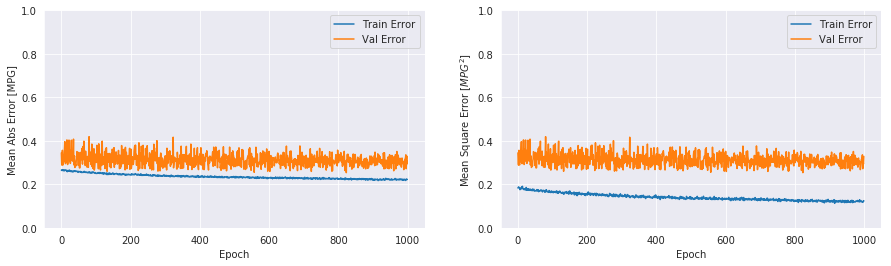

In [0]:
def plot_model(model):
    hist = pd.DataFrame(first_model.history)
    hist['epoch'] = first_model.epoch
    plt.figure(figsize=(3,4))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.ylim([0,1])
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.subplots_adjust(right=4)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.ylim([0,1])
    plt.legend()

plot_model(first_model)

In [0]:
 hist = pd.DataFrame(first_model.history)
hist['epoch'] = first_model.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.120485,0.221956,0.120485,0.284751,0.335559,0.284751,995
996,0.117951,0.223549,0.117951,0.189932,0.271819,0.189932,996
997,0.121877,0.221133,0.121877,0.246622,0.308236,0.246622,997
998,0.120503,0.223375,0.120503,0.220811,0.293181,0.220811,998
999,0.124616,0.222406,0.124616,0.277768,0.328535,0.277768,999



...........................................................

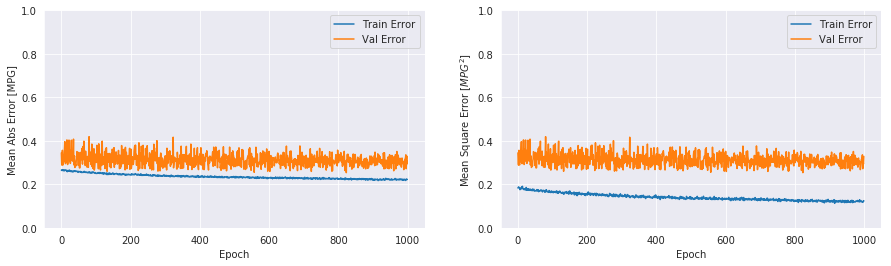

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

second_model = model.fit(norm_X_train, y_train, epochs=Epochs, batch_size=32,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_model(second_model)

In [0]:
loss, mae, mse = model.evaluate(norm_X_train, y_train, verbose=0)

print('Loss : {:0.2f} \nMean Absolute Error: {:0.2f} \nMean Squared Error: {:0.2f}'.format(loss,mae,mse))

Loss : 0.21 
Mean Absolute Error: 0.29 
Mean Squared Error: 0.21


In [0]:
y_pred_nn = model.predict(norm_X_test)
y_pred_nn = y_pred_nn.ravel()

In [0]:
print_results(y_test, y_pred_nn)

Perfect Predictions:   206
Excellent Predictions: 156
Good Predictions:      178
Quite OK Predictions:  70
Bad Predictions:       84

Percent of Considerable Predictions: 87.9%


In [0]:
print_error('Neural Network', y_test, y_pred_nn)
 

Neural Network MODEL:
	Mean Absolute Error on Test Set: 0.29
	Mean Square Error on Test Set: 0.20


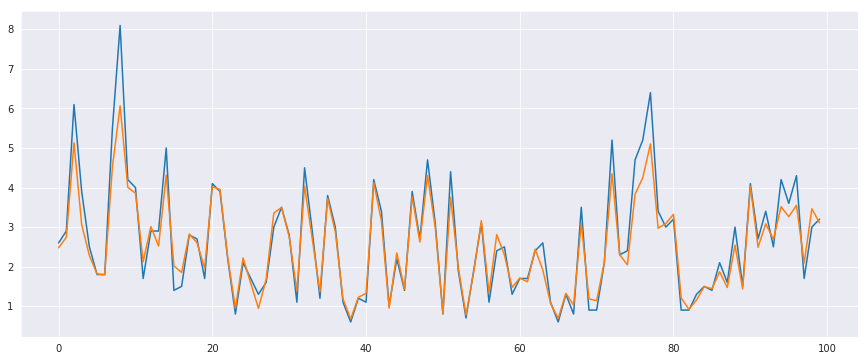

In [0]:
line_graph(y_test, y_pred_nn)

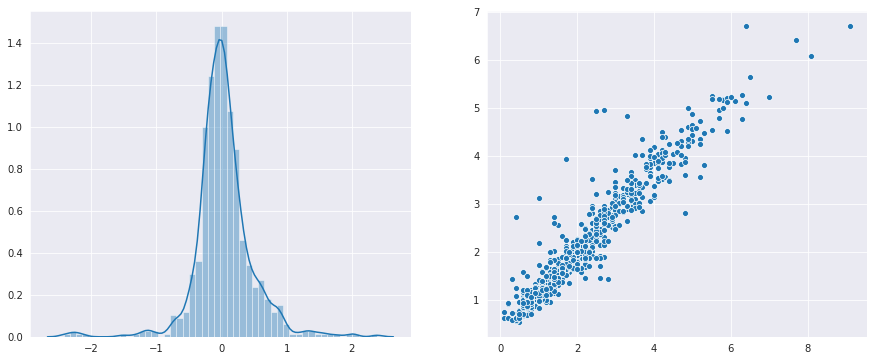

In [0]:
plot_error(y_test, y_pred_nn)

In [0]:
def circle_outliers(xlim, y_test,  linear, randf, svm, nn):
    e_linear = y_test - linear
    e_randf = y_test - randf
    e_svm = y_test - svm
    e_nn = y_test - nn
    x=np.arange(0,len(e_linear))
    s_l=[]
    s_r=[]
    s_s=[]
    s_n=[]
    min_s=0
    max_s=500
    threshold=1
    alpha=0.4
    for i in range(len(e_linear)):
        s_l.append(min_s)
        s_r.append(min_s)
        s_s.append(min_s)
        s_n.append(min_s)
        if e_linear[i]<-1*threshold or e_linear[i]>threshold: 
            s_l[i]=max_s
        if e_randf[i]<-1*threshold or e_randf[i]>threshold:
            s_r[i]=max_s
        if e_svm[i]<-1*threshold or e_svm[i]>threshold: 
            s_s[i]=max_s
        if e_nn[i]<-1*threshold or e_nn[i]>threshold: 
            s_n[i]=max_s
    
    plt.figure(figsize=(15,6))
    sns.scatterplot(x, e_svm, alpha=alpha, s=s_s, ci=0, color='black')
    sns.scatterplot(x, e_nn, alpha=alpha, s=s_n, ci=0, color='blue')
    sns.scatterplot(x, e_linear, alpha=alpha, s=s_l, ci=0, color='yellow')
    sns.scatterplot(x, e_randf, alpha=alpha, s=s_r, ci=0, color='red')
    
    sns.lineplot(x, e_svm, alpha=alpha, label='SVM', ci=0, color='black')
    sns.lineplot(x, e_nn, alpha=alpha, label='NN', ci=0, color='blue')
    sns.lineplot(x, e_linear, alpha=alpha, label='Linear', ci=0, color='yellow')
    sns.lineplot(x, e_randf, alpha=alpha, label='Rand. Forest', ci=0, color='red')
    plt.xlim([0,xlim])
    plt.ylim([-2.5,2.5])
    plt.axhline(-1*threshold, ls='--', alpha=0.3)
    plt.axhline(threshold, ls='--', alpha=0.3)
    plt.axhline(0, ls='--', alpha=0.3)
    plt.legend()
    plt.show()

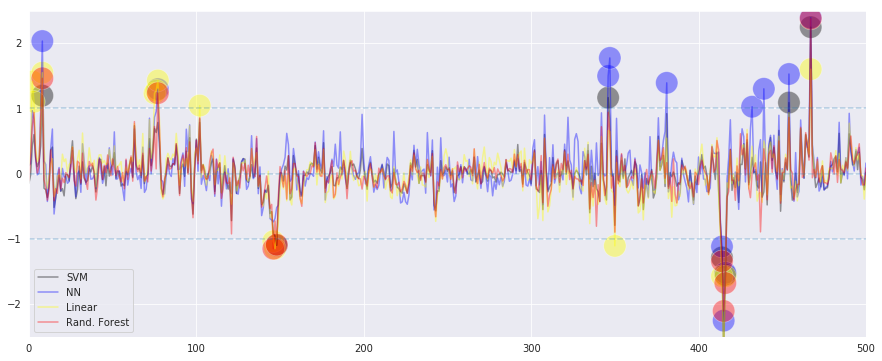

In [0]:
circle_outliers(500, y_test, y_pred_linear, y_pred_randforest, y_pred_svm, y_pred_nn)